<center><img src='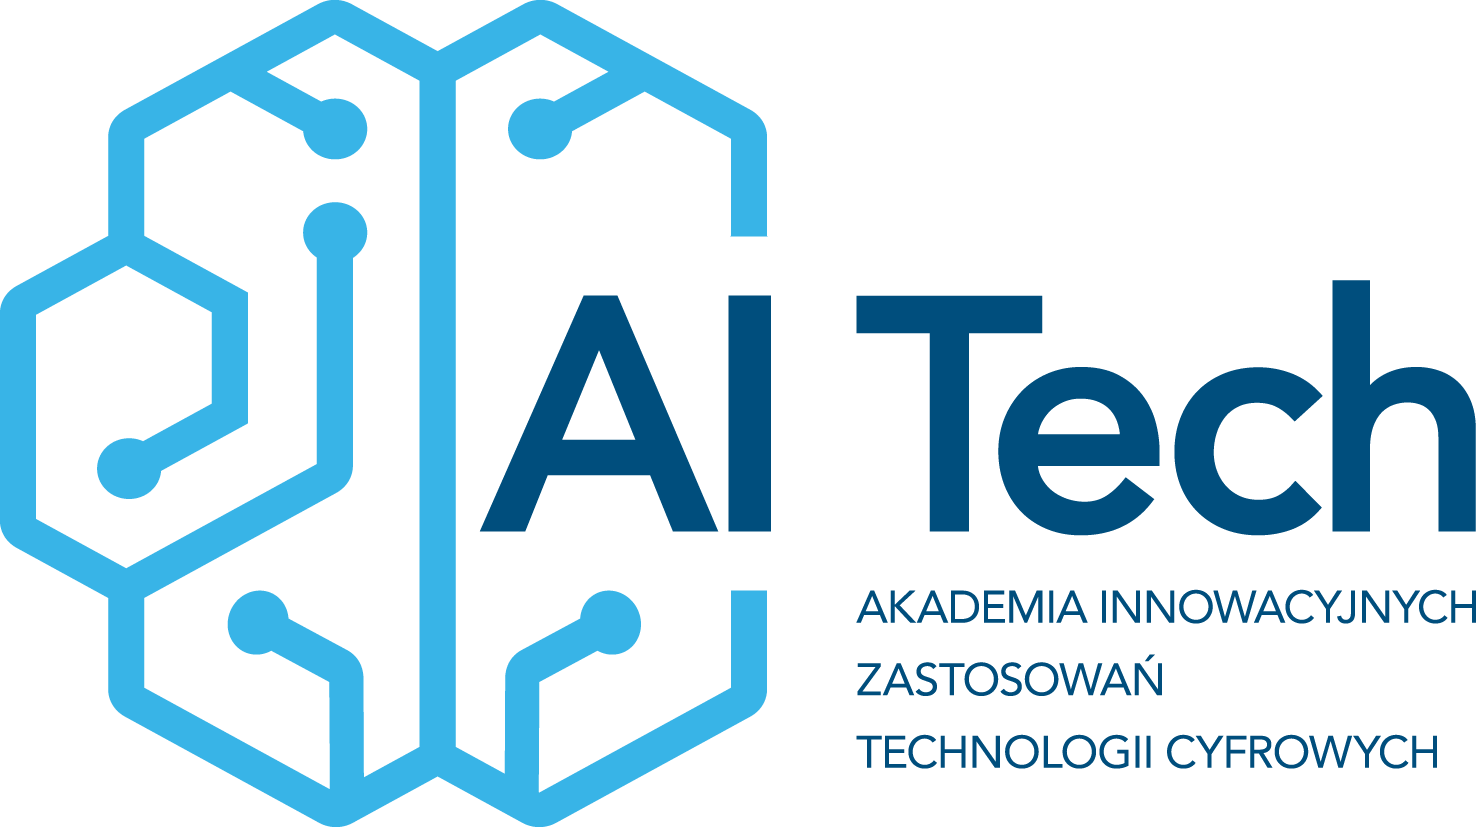
' height="60"></center>

AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Program Operacyjny Polska Cyfrowa na lata 2014-2020
<hr>

<center>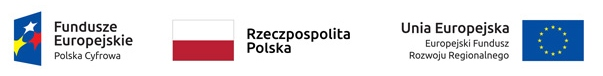</center>

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego 
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej" 
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>

**Author: Tomasz Pawłowski**




# ML in big scale - Big programming assignment 2

Implement a SVM algorithm on Spark using stochastic gradient descent optimizer. Utilise Optuna to select SGD parameters. Make sure your implementation of SVM allows for Pruning Unpromising Optuna Trials.

The input will be given as `RDD` of pairs $(x_i, y_i)$ consisting of featue vector $x_i \in \mathbb{R}^d$ and label $y_i \in \{-1, 1\}$, where $d$ is a dimension.

Objctive function is given by: 

$$f(w, b) = \lambda w^\top w + \frac{1}{n}\underset{i=1..n}{\sum} max(0, 1 − y_i(w^\top x_i − b))$$

You can assume that gradient of such function is given by:

$$\frac{\delta f}{\delta w_j} = \begin{cases} 
  2\lambda w_j − \frac{1}{n}\underset{i=1..n}{\sum}y_i x_i \qquad\text{  when   }\qquad 1 − y_i(w^\top x_i − b) > 0\\
  2\lambda w_j \qquad\qquad \text{otherwise}
\end{cases}$$


$$\frac{\delta f}{\delta b} = \frac{1}{n}\underset{i=1..n}{\sum}\begin{cases} 
  y_i \qquad\text{  when   }\qquad 1 − y_i(w^\top x_i − b) > 0\\
 0 \qquad\text{otherwise}
\end{cases}$$


Provide an example of using gaussian kernel with your implementation by transforming the feature vectors using RBF ($exp(−γ \|x − l\|^2$) for all landmarks ($l$) in $x_1, x_2, \dots x_n$.


Usage of Optuna should be as follows: 
* Start with multiple variants of parameters. At least percent of data in minibatch and learning rate should be included.
* Repeat model training using successive 10% batches of data.
* In each repetition drop portion of the least promissing sets of parameters.
* In each repetition start from weights calculated in previous step.


# Solution

## Setup

In [158]:
!pip install pyspark --quiet
!apt install openjdk-8-jdk-headless &> /dev/null
!pip install optuna --quiet

In [159]:
import os
import matplotlib.pyplot as plt
import numpy as np
import base64
import scipy.io
import optuna
from typing import List, Callable, Tuple

from pyspark import RDD
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.mllib.linalg import Vectors, VectorUDT
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [160]:
spark = SparkSession.builder \
                    .master("local[*]") \
                    .appName("mlibs") \
                    .getOrCreate()
sc = spark.sparkContext

## Dataset preparation

In [161]:
with open("svm2.mat", "wb") as fh:
    fh.write(base64.decodebytes(b'TUFUTEFCIDUuMCBNQVQtZmlsZSwgUGxhdGZvcm06IEdMTlhBNjQsIENyZWF0ZWQgb246IFN1biBOb3YgMTMgMTQ6Mjg6NTQgMjAxMSAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIAABSU0PAAAA5RwAAHicdFkHWI3v+z8iMzMr2SPzi5bxDXeEjLKpyG7wRSIzo+wVSUZli6wklWQ2lJIT7ZxK43RWZ5W99T/9zvk873Xl+nO57uu87/M+z/3c43N/7lsLHo/XfRiP11AjG/O0svaPvu734vo8np5G1tP8ddTIJpp/1ZY8XlbGH+uHax5TDb/7mMiKBxTbVnE3qvVDGsB7Yb5C9pzWmzbMX/crnZZIrL4dqp9H20MCOwT7FlFu8LZJ30oqSM/t2Z6LI2S0mq84aDNMTvHBQYOT5ZWkPV1GqR8ivBOeyKizSaerZTdllOJX/aX7XhmV2dl1WPZZxtat/fhi8tJFMmpvnlS0p5WcyQT+5mrDRkK6wev45tLlUvLyXXKsa3wJLbK/EBUSUUxXfHYfaWdZRDGS1MXzc4vJ6Oj2Re/nlNFc81X9u6tKqepVsKrpjnw6Jl742XdrFsn5o3tvr8qgvu791FsCX9Ej94WhYutE6hnxdVPYwGhS+kt2jm4XQc1/GzqH33hIoa+LbZK+PqMol9odEsg9JPK3i18ijVweZBjz8iltXuHo9yj/EcGO09puHxxh94BcCxqFhrrdYxL2NQ2KHydJTybbV7u6/lf0gjzMbhlUeCTRQPNrnx80eELGrr/dlj1Kol4r+L3l+s9pr+tqmZtPMv023/Mt4Vg8O690r3TKzeoYpq++88RLkd5xbL9AnuX91XdSaOTZYzyP9ik0eeUw/+dLnrHzz9Qc3/nz39e0krd2V4OULLpsF/oypWMOycwvlfiF5NEpt48jDCR59MloxtqJGdl0wN5Foncmk+YF978T3yeTvC3yAr/bvqJVwQapH43SKfJV9UWPS2nEj+q7K2NkAV2I1t+b/7yQxYtl9Gm97D9vmcT75KBPX2dtKaQ1NelTAmcV0oOo8e7BE94R8W7anyt+Rx4J0gOtx5XRej8X/xnRZdQ/Q7KuI7+I+V9jnEvFsdw6C/u3O81elFEHt8vncwYJdecI6bPdENPTlUKdnUVkILl7/KGZmMa6uWdZtZPozhPTKEGG384YKYvTdKPDViUiCYkE4gXd5knpllv+LOtCKQUYjIy9cJmTiGetPSvpmmBUiz1bK+mIUblqbONKtl/36GjZ+abcdzgP55iENbv3I1RMISaryWi5iE6at9385CWnF/LNwveB9W6hjA742d7ce13Ozsdz5FumgbC+1U4xDUkY8+9GVyHN8PrQ09CznOqZlyZO71xGe8yOmnRYXsz8Av/XRmGr2wXk69aq29v3ReRnl3A3oHc5889UiWPJ3JZFOjsX0vWMEc1n7iugQW57HzTqkUvNjfxnNZmex9bDP+P4feYW2ZfQcKO5+9cNLyenhAYe7+wlDAd+rXd7PO5iJRU6fZqm7yynhX67NnaOl1Ck02Dj814SZpdLRsmNNv0SMnz4LkjbOHtKOcv/eW5TFGublDG8yDF/muwYVkT/mU+zmVMuoF52MwcfXczpizzQ2i+T5cfgmh6/v2zk08I/Nj9UijSyNj/YUvkthUJqYc7/Bf3iXR22bn0qy9N9QVNvxZ59QpP2zePfuR/L8v42/2R+aZsEln+ONdKhixclMPy5af71ePXTVJZHwBvgEPBplds/+ld/c3iC99FdlwdefhPJcAE4rrnklj6T5dTK+j/DvpsVDFdDvXYerrCupOnWhkufz66kOTw/98zMAoaX2bwSvSaHc+h/4RqXS7bSX21Td2UzOwEXgBu7a+64pE7MpfX2u/ivr+QziX3O+5ok7b+eTSWSo4FJTzKpPKrp2XqDs2iEncWkxNlZNDsj/JpvzBuGM1gHvD7ufmbtDscMXT5l0TSfL70muOQwPbCf9n7ZlMef33TSzxwKMvO0nuqQz+7lwG+8tuW4tzo8KGS/xwVPDDxims/iH783Gf3Jad62gARBBa0PrM5lddAlKq4mbUMe9QtpFJl2N4fdE+vwHt+XGq2Z20bwlsUfcO9W8P22x78UsHhEHiH/oAfyCbKbb67JNDVnZ3wnFFc6z5wioIO+NjdmRb+l/JqR/DMdilm+ok4CN5Vmv64b9yuhExlzP3YOeMfyXZtXnH44D+fgPfbV4hpXn5HvnrWA5l2mu3+Z7v7lDI+Qx9Xxp5RvD4ooe/2lA4WxYlpg8vz99v0SGqk5jWz+xlnE7zDJxuQexpwEjmA9cBv7vg7r5Xt2gpjVgzCDzpnZp8p1+FfGeMY/wcu3Oowupm8dw0fkzS+ikT6GTVt7CpisW58gf9KB7x92l1Pxh4CTnyKF1Nprct6mwArqY23/z4JVYqpyKlgxcoaI4ZrW/hIdX+H0ldDV0mfHpPQneOz2JalSxqOwDnypbUZ9R1FBpQ4XKqkoPir76kk5w88fBjeGh7pVsrqA+oF6wveZFL+ji5Ri7fZXfDcQ0zm/Ac/jznL4ClzVxkWFLn5ETO8JH3ntv28UMTtivZYXCHV2FDF/wj+ok9r8lVOO27n9N5IUdN/oeo9b1UrST9jSsPkOtY5PVNEru5W//6lXRdsN5p37746KCsyMjknNlfRVzN+0b4yC2QH147FBTWXDwwpqFp35emV7FXmHnen4aoOKIv2av1P6q3XxrGb7notvsq9xHLcfpItX3ihbFwUN/djlV/IuuY5vVjCprdsldMds9nyfqZlUYTG+3R+DDFYPUCdQF4DjO3mzzo54eJsul/fLHVzvOnsPfrcjY71Adu45tbZwa/N590v6dsfUZozNXTrU9fzikdJwtg/qAHDAx9x04cG8HIar2nvk6Oq3gOEP8K9RzAb9ooMcHiDfwauBQ8hr8Llf1ybsOPG4nPUB7gZeu4c9rGC8CnwKcQLeg3wGr2nq+96g0w8R2wd5Cf4GiXjS4pmI1X0tH6ygR4Ju/R6sqaDJviHzY/OFVOiX02ruFuFfeYg4hvwSpYqx7FnB7gN+BJlkNmxDNAl1OMetr7X25gEiljeI74YfHdKcgzm+ArxBXtWV4DPABeg/UxAZFnWjnNrxKowsPpWz++A5cAYS+Qqc2SbYVNgpQMz8AQmchV77nVZILY5wvBD7tWx+ZGbBfC7fUb8QD6ivkOivUAfxHHkB/oB1U6K3dm74MZsUNZ0lr5pxdQVxivNQZ8BPDUN6nz75WMDq0ZiMl0fsEvL+4i3vXYab/8h6zfjAZrt3pxYOLaUX8W/iPC+Vsb4Adm/SyfyQdyJnlwZHg8c/XSLR8TYZqy/X6WdAzygOZ13DYv6c9q1g8VWXZ6Pewa+IIxfrL95fbStYfCGe4WfgC+Lb1knTWUdw8QJ94Z+lRsaaFBAzWbfe4Dz4FfmK+EU+go/fi1deGBUuYXUIfWRmSDeflTOfU2LNvKjlvZIYfwWfDRjtN//2gfus70XfCl6K/hkS+6HfRV+J/dHH9hvdRRCWFM3w7zT/3pPbXWMZH47wH216eUQkw1Vj/8bbLY7cYucCT1P+RG37EJnO6izqEPAdeI86g/rzr/VQW//FVbTId8cGebpSNx9RkJ3RiEvXBnK8GnFyKLrnf1feyJhE34j5CPi4myAwQXJOQSZeg6puHVDp7qUm6fo9l1vcriKrMHX64KAqeiPQG6dYqtLlDTdnAZ6ij4VEXqPfQt+srb+ZVGS60WFTIp+mv55R/N4klc0H4Gf0OZgDoR9BH4P5Bfoj8PNnbg9Xb3j9klSuRStXjX/B/Ah/w4+oX9gXfQ+eY76C8zBXQbxg7oB+YGGn+OopJ3IpvMYraMiQMlaXwcvAT7tIh5UvCi5hsoWdR1unVe+YrPscvBh2DHadrnfWi5s/aflZKeO5+B7rwKdPBWf/WKBXQmZSo58njr5l9Rp4+lJya+uxtHyGh+hbIlzNOr9xf8sk+hXw+0mdivPbX+DmKKjvmKfgN/oC8Ff07eDR4E/IB8Qx5hfAu4sS0QSTMo5f4jck5hGIU/Aw8NMZYVmiZX4cjiI/gDM4DzLZxMxr11Quf8BbrbxaNindJmU4DdwC38AcBfhWl98CP4GvwGnwAPAQ4Dv4CfgH9kFdBX6C7wLvTU1+P217Qchwvu45iBvMLYw//is8frSMvYcErz4sqTfog6KMzW96+wytLt5Wyr5Dn4X1eI44zRA3tOkyr5TFM+pi3X4NfSLiGOsxz8F7fF/uM1Bwr3U5m+tAzxSn1pZZ7mVsvgH8rR98fkLVnDTdnCaN/XatZxi3cfhLNm8Bf8ZcFHih5f/Jf803UYfAv4FDWI95TUf+4h5erulsDgzeDtyBBG5hzoL6hPkE5qHo5xAP2vmRhM31MF8Bv0be4lzMP8CPMC8BvgKvgXuwJ+4RFuI0td7KN2w99sU8pe736CswX6nP396I1mUyvgZc/e7e8P2uLm/YOvAq6Aleh3kM5h+Yo2AejHuDf9TlPeDj4F+QWtyU0EZJ1zbPvkr+mpvC7lr9uL4D30GCD6HfQN8KiT4B+oAHo/9AHoO/YY4MHAEvA7/e6hU3b5ujmPUDWnxXM14BeddkupO9g5q9d3a6Es2/oqbezT1WNZuuYhL8IIsSUw6HqHT1WcX6V619q6iRyfDD4ffVrM8FnwB/eODjem1yfxUts/uxrf8olW6epdLNQZU63q74f/VD3wyJ99r/L+DWa5w7w6Pobx6D76An+v2694SeZ2vD2ofTC3069Mf9jws0BWlflS7Pqtj54G/QQ9svV5F8gWSDk10F5Z25dj7klYhEj/qL75+QEM9TKfAy0tSd3s5pveIUZNuli0OvxypKaWC5vZmCk9Wr/Us8u6nogirLWN1LSTMvilqcTZOThmReFI6Q08u5g3bOdlTQw6THzsmblbpzlLT+2gX9y0/ktHDmlMbz5lbSzfhFSxN3yCj6XpuP4VflZJxXaZ0/W0kKq/h+Y31U7Dt908z7Qy4p2P4HJ8cdt/VUsPerGwg3/tbT+EmsKaRj1EzPmABF2MkCJdWa2/KkgtxtaiuBgv0ea7BB1UzGSdPgAR1P5cop9wG/MipITs719nn/aCwncYhe8PkUGbWqv/Cn3g8p/Vhk4+k8UUruOa0TMpZJyGvf5ocHq0Q0qih0eLGtiHo0fPRF/1OF7r5C+vx0f1mcn5COeh+cuLlVBW2JtV0b5y+i4bdydoVfF5F+YkXRY03/HNND46FnUrp67NjtgHcyZiern+l7PrWV0+Z8j8eZtf8vUL5wsNBKSQ6RR7dEnVUyO4sHtI/vH66gCN9xo3c0UFCrQM8e/hpeotWL88PVP9779L+qdH5X07IrY5teSFJTaMT9rzdvqUnctGp961IV3Rwy1cryjIqafogOUJiomV+Cn9Rze7ZHSTukHfrIhijZ991PZ3Q+Uaim0kNOQ/Z/ULPvcF66pb6Z1RHOL4WaMp2+itP7f7Szn8YPW2sRWUUrehXY97+rYvpAP+d16+Z49Kyi5Ji16rsXOH9jPe6F9Sap57MTvdU6f/2tz6BJ5u3t3VV0bP5SjWtVOv9wdtX2DUoauGL+MlcLzq7Gn1sdVXeX0yOzG8NGBFTSTocGNQsmV1J6SkfH1HUyWlOriKWM3uz/pekE5Ww/nGv3p6/P1xZqGvhtzcH3nTj7rplzvb7TdE4ividmOLxM9VAzfRG32nxW0KH+AeOHhHL3v1G6745giprlMe6H8/t2WL6kS6qKfYfnyO/dN37yrsaqmYS+s3yeJu3+qdT2/YYqajZuazdbLy5esA/Og93HnjtgGPRazfTDfe4uMdaUVhWLA+Tnz9dDpmQuVjJ97KepDGYv4CSe/x8AAAD//2VYe1hN6RdGNzQkUoYicqmUFNEMWZUwch0y1SiXSJFL5JIo1yjElIgQiUjKNT9pKpKJiKJQnTpnn30u+1zDKIT8Mnuvbz9Pzj/r6Zy997fWu973XWs3vi59rGCKGvQcK3Idzqig8cAt2zi1EjJnrds7Y6kKhJ8mdWkxVEPTqYVJZ4r4OPbSix2XL6jh+N8dlxXuUkOH/z5qmOLqmT4uVgXDQ/4MDBqtgsNZvl8yriqhhjl5WuyihKIlEepgRwXkvBlh9taCAccuZu86a+XQZB9+xy5DDpPLfR6VrpaBtGvjOmOhFMJjNuXFNkogSm42hHGQgONx2z5HqsQksudK4OCfi1sWTJSCocfmAVPCpaAaV2Ttvk0Kkjs20txEGURtGj5tvakcnjUz3T4YM2D3evL4mhkMSFM6HT/1gI+m537en3FDDfGRsZM39VBBnlh8UeCphDtOF8e4JCigh07A504tcjAMPBO60E1FcHs0zy56ri+PH9bdVLBHdPuAEm52fL2981sFRAwdPdUuU/HDdZters6v8FfC2L5351veU0CHMHVN+M8KOG6nBadTfOzX1CNea6kEUxP9oL7lCvDYuqh0W0cF7IqturlfwYDy8fOZ5UEM9Av6uizwVzmU3FyjvZIqg4vCmOwaLxlMsbDwscqXwrNl1fIVw6VweL/j1YO0BHyuxkdcPyHh+i3h+k9D1f+eKK4fE4OvZeScobkUBO7sWxjTJIKQG8rw3CMiKEn67WxypQjGfS7b9d5EzNUjhsCeIyTGAhrsfhtlOiNYCvrGmcvNXkghb86znbMXyKHsQR/f0rUMVBskbuouVRCce5e4vSrcroRjAuvrL2fzuKcGFDYtdlVw5zKQWbRg8b0oBs4dPJiVUM8QfPB6Nk+G8Gr4x1Wxb/vKSN15xfn+JZskkN7/bKVFCQ3BE1uPu2+lub6IufPFXB8o7nyK/J6qqeyntZJwepBAnE2Cp0O6FIaWnnp+L1JG+oDnz5ip+Wnu/Lbfx+677JxEw/TVJn6h1jRIbU2LbC7TEEAFjBCPk0B18vlTKY8l8GbloYawAVJyX6bDtHHOyVJyTvs6Sgb7P7S6TcPvpyXdTzwUQ3O3thNqKI4XIg4nEccbClatfzprrTkNEbemrLl9SEKeV+as5zRuvxSUqk8pUieeN8ijru9uJKiGykg+qE/kEfY7tubxrRd/yAgemDfy4IGu81ZDFa/PnRc/dzh3SwaWR8vNE2tlEHjWvWtqMe8DeD3qfM62guKdnyUEt9ipt/+aEkZDznYP1yhdGm5c6/nv5XM8b8dP+8t49mKK8x8KPk8wH+y5mYIxZS3lJevFsO58ql7a37yfsL7G14V+cq41Mkbvw48R8WD796M/snmqoejf/T3fm6nh81MHr4qFag5/NRiHT63e2EsDq7wv6PjN0oDjZp0nWw00xFfZ/Hles7pjQD/t70Ppebx/oR7QZ9j6ef9A30B/Y3nD+zXLHyWHC69DjKhT9HPUpWi5E71qSJs/Hg4beEikJM9jdaclcZjZkkUWpRrO57UEL8QJ5wfm1a9a4fZyblv93Jxi+6+BK4v6vV06VkP8uv11LJ/531m9qjmdqwjPELd1vfcLTV7KCW9RB8jv2ocb5paF8jpj/Z4G/44xkS2dxURn7FwREV2hHtB3ke/oC/5r13qvHiQn399MUGUkveL5h/p/1EY14QReF3hf4a7TLttbZbBSV7zhayfe39CX0K/YftNcX2hw/2m9xpChiU+jblAP7JwRQ9Jni32dvlLET9j5REGtS6D9hBiK6zsFAzdmVGzu9qPfYMS5gRG/j807tyI/TgSGzw9MeuEnIs9DXH0qbpaUhfDzHnWOfdjVh6k1q6B/0H/A716d/5hHcfrgnz+9ocMooTt/Lv7O8kBE6saI+eD1iAerAzE3r3h8MbL6lxAfRf+s9Y3b/MccObif3Nvr2FMZVA3Luz/0upzsQ6u+E8GZgZsDvz2xLJSDMM7PYc87vr+sP0gJT9Cf2s8vxA9xQP8j86d12LYP3WUQMXn+Ec+NcrLX4FxF3oVYvZphc4X3Ocwb68B5jnsbqz8J5z/83ER+4P6CfoH1tok6zH8yz2fkN+aHe1v7uc/6uIKrV8nxRUm+x+tRb4f7TXrZt0xO8EX88flsngrir0MvbNyTmc3AQeV6S5UNv6/ifahb9H/co1ieKLg5qyJ1o+/iHEC/Q7+N9tH9Nn8qvyeyvGUI7tgn9CfcQ5B3uL8N1L/TrPeeJnMT80U80MdxT0F/Qd9oP0dx7rePyCOsH+9n55uE5Ic+g/igr2IdmCfyDJ+Pc7f93srORynxZYys30vI9fh8dr7y+5nePbouf4+M7Mmmo+2vOaXIf6gHdYd8RD3jfoh7BPoaq0MhXK+KLKo8SMHU4EWSoHLexybtMhkf409Bz4IDgXlDxOC0sXhamJKGdf8tWjS8csy57WJLgbnHkRTX2SIYkbgx/dBm3l8U0TPdo8eIYfW9OQF3p1HkHPM2WnutosD6bV4vdVEbXtkjo66kMZzeVbD4QebL4ssabp/SwFz/ec0BxlrQSS5NSXBXwacdWeN3jFTC+kAjzRI9JXzJKo3K2qCA1mq6sPoOA16eH83caTmJ745mDTixlIG7FVaTn9krwED1zVz2WAH5W1X3I9OV0HFVll/wFxVXjwZyW492+PJCDacveehcW8mfh8+/LbWyUSyWw618A6bQnIHiFtj7aR0D2RmquBxDIdhcC92SP6QBViY1nYhTCGDqq+mFNbI6+Id6ckXWoQ5ylnzvUC2sZez7N4TXwWtDvZUGVvXgmz394/loIVyy65pvHSmC16l+Pc8MpeCv3VHj4mJFwDiWjXIwaHufcSv42XlhA5Q/+f4RwCWjwY3mZXUQlNkUnW5RB3fOJvW4fKkWZAY573SLRaBydrW2niTk3o8aYJ5pTICJqwCc/ATblv7K54Xfv4nbcGnrs3oYeTL0WNpbIcdTEcyel7bD9xYFwS+M75YHisFvRYEwpLRNb0GUKjRABE/jXG8e6i0C5zfpfZu3NJD6MB/W9xpA4uXa9upbT/JHnBbPK/gy87AAcmf6H/SxFIC93rmvRlf5fDDOLp5eV3S9nuMnHxFHReqG+KM6AoKH5l22kSq+luSBdeLzsV+ID0bEuX3EfOsXumrnZ/P93DB+2Rmn1hqCG/aN9RURtwcIOf4ICU4PI5K8IjwauPcsIeER1nutxeonnaN8nYhPe16x/eDrxPoQZ+QB4oT3f3KU5QyR1JI6qBsbwq6OreVx5XiYvCbKd423mPyNdWL/T97Prb3fIIKR0zO6Tj4vgiXq3cmiKiGkBX9/Eeb5WmmpN2ugTx14qKen/du3FsZkm3TKK6khfcH+YsS8B3dbHWo4SwQFv/hnuarrCf7IY6wDz0P8B9G/21JdKHiycGB4UIWI4Is43ItPsk/cKABRs26cRttA6kO+nzHT+vdZ3sjNmUbOpxrh+3rrkaOF5pT+JklnG6HBPKe6f7MWjrzOLajv2QiT3hQdUfsq4GzVAs+6a0pY0/3VCqMtKhhS1jDnabKK+NdjI39pl90KePpL2yR9xMCeASdnWQxn4Hn81Yuxc+UcL+QcL2UcX2RgEO19P/qZlKtDCl9DXIJWF0pgrjrEXPlBwvm+DDrZmrvbTpLDguFp+YNnSiHhrfWRN7sl3LyWcHsGDd2+XNzzNZWGb4neGcd0JCSyONPc/KFhn75NRNc8MTevKAgd5uUxSNOGa69kundnFdj2N6seNEgJLntDc/cWKGDiP+nexb34v7v0Nl/Qw1jB8UcOH5R0WqNWxulBBhP07kbox8uh+3Jv0dITckhcUKX12cFweyTD7XkKbg9QcvuGkpyPfm39vuXwRwEfEWf08dJ8qyW5n5SwZYZRV6/Ktrlzfue+S0IV+Rv9H+/H/PH7q643BrvNUIKu/IC1Jl7M7b9iohNWR2JIOf79Q3H/T/gxIn7o+6gr9An83n7Qvkf9FvHX4zxA33BzEOSNfN5AfON9fbZdpZ+A+APqDSPqfebwGLcRa2uJjnCeYESfQP9GH/zFU3DSS5/3EdQb1nX+daVLVSOvuyEBoz4tOyEk96HuvDNrdLLdeP+40Em7uXU0xb2Hiwm++Hz0S/RBzBt9/v8NnMS0DwAAAD8AAAB4nONjYGCYwMzAwAakORggNAiwQvnxQDlGBhBmZKgE0kwwsaEOGAYeUN/ddA4DCkymr0MpT650tp0BAIEaA+U='))
m = scipy.io.loadmat("svm2.mat")

## SVM with SGD

In [183]:
class SVMwithSGD:
  def __init__(self, learning_rate: float, lambda_regulizer: float, sigma: float):
    self.sigma = sigma
    self.weights = None
    self.bias = None
    self.lr = learning_rate
    self.lambda_reg = lambda_regulizer


  def fit(self, x: RDD[List[float]], minibatch_iter: int) -> Tuple[np.ndarray, np.ndarray]:

        num_features = x.first().features.size
        W = np.random.rand(num_features)
        b = np.zeros((1,))
        
        for i in range(minibatch_iter):

            minibatch = x.sample(False, 0.1)
            grad_W, grad_b = self.gradient(minibatch, W, b)
            W -= self.lr * grad_W
            b -= self.lr * grad_b

        self.weights = W
        self.bias = b

        return W, b

  def predict(self, x: RDD[List[float]]) -> int:
        return x.map(lambda data_point: 1 if np.dot(self.weights, data_point.features) - self.bias > 0 else -1)

  def gradient(self, data: RDD[List[float]], W: np.ndarray, b: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        def grad_single(W: np.ndarray, b: np.ndarray, point, condition: str) -> np.ndarray:
            y = point.label
            x = point.features

            if 1 - y * (np.dot(W, x) - b) > 0:
                W_ = -y * x
                b_ = y
            else:
                W_ = np.zeros_like(W)
                b_ = np.zeros_like(b)

            if condition == 'weight':
              return W_
            else:
              return b_

        W_bc = sc.broadcast(W)
        b_bc = sc.broadcast(b)

        
        weight_grad = data.map(lambda data_point: grad_single(W_bc.value, b_bc.value, data_point, 'weight')).reduce(lambda x, y: [x[i] + y[i] for i in range(len(x))])
        weight_grad_total = (1 / data.count()) * (2 * self.lambda_reg * W +  np.array(weight_grad))

        bias_grad = data.map(lambda data_point: grad_single(W_bc.value, b_bc.value, data_point, 'bias')).reduce(lambda x, y: x + y)
        bias_grad_total =  (1 / data.count()) * bias_grad

        return weight_grad_total, bias_grad_total
        
  def transform(self, X: RDD[List[float]], y: RDD[List[float]]) -> RDD[List[float]]:
        def rbf_kernel(x: RDD[List[float]], x_i: RDD[List[float]], sigma: float) -> np.ndarray:
          return np.exp(-np.power(np.linalg.norm(x - x_i), 2) / (2 * np.power(sigma, 2)))

        sigma_ = self.sigma
        rdd = sc.parallelize(zip(X, y)).map(lambda x: LabeledPoint(x[1], Vectors.dense(x[0])))
        return rdd.map(lambda x: LabeledPoint(x.label, [rbf_kernel(x.features, x_i, sigma_) for x_i in X]))

  def loss_(self, data: RDD[List[float]], W: np.ndarray, b: np.ndarray) -> np.ndarray:
        W_bc = sc.broadcast(W)
        b_bc = sc.broadcast(b)
        v = data.map(lambda data_point: max(0, 1 - data_point.label * (np.dot(W_bc.value, data_point.features) - b_bc.value))).reduce(lambda x, y: x + y) + self.lambda_reg * np.linalg.norm(W)**2        
        return v[0]

  def loss(self, data: RDD[List[float]]) -> np.ndarray:
        return self.loss_(data, self.weights, self.bias)

  def accuracy(self, data: RDD[List[float]], W: np.ndarray, b: np.ndarray) -> float:
      def predict(x: RDD[List[float]], W: np.ndarray, b: np.ndarray) -> int:
          return 1 if np.dot(W, x.features) - b > 0 else -1
      W_bc = sc.broadcast(W)
      b_bc = sc.broadcast(b)
      return data.map(lambda data_point: 1 if predict(data_point, W_bc.value, b_bc.value) == data_point.label else 0).reduce(lambda x, y: x + y) / data.count()
      
  def score(self, x: RDD[List[float]]):
      return self.accuracy(x, self.weights, self.bias)

## Pipeline

In [185]:
spark = SparkSession.builder.appName("OptunaSpark").getOrCreate()


# Preparing dataset
X = np.array(m['X'])
y = np.reshape(np.array(m['y'], dtype=np.int8), len(m['y']))
y[y == 0] = -1
print(f'Class 1 shape: {X[y == 1].shape}')
print(f'Class 0 shape: {X[y == -1].shape}')   

EPOCHS_NUM = 3
TRAIN_TEST_RATIO = 0.8
SEED = 2137
MINIBATCH_ITER = 2

# Define a function to optimize hyperparameters with Optuna
def objective(trial):

    learning_rate = trial.suggest_float("learning_rate", 1e-3, 5e-1)
    lambda_regulizer = trial.suggest_float("lambda_regulizer", 1e-4, 1e-1)
    sigma = trial.suggest_float("sigma", 5e-2, 1)

    clf = SVMwithSGD(learning_rate=learning_rate, lambda_regulizer=lambda_regulizer, sigma=sigma)
    
    data = clf.transform(X, y)

    for epoch in range(EPOCHS_NUM):
        training_set = data.sample(False, TRAIN_TEST_RATIO, seed=SEED)
        test_set = data.subtract(training_set)
        
        clf.fit(training_set, MINIBATCH_ITER)
        
        intermediate_value = clf.loss(test_set)
        trial.report(intermediate_value, step=epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return clf.loss(test_set)


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=4, n_jobs=4)
best_params = study.best_params
clf = SVMwithSGD(**best_params)
data = clf.transform(X, y)
clf.fit(data, 1)

print("Best hyperparameters:", best_params)

[I 2023-02-09 00:42:16,636] A new study created in memory with name: no-name-1faa64a5-4f87-41f7-9991-956ff084f203


Class 1 shape: (480, 2)
Class 0 shape: (383, 2)


[I 2023-02-09 00:49:16,923] Trial 4 finished with value: 88196.51783511874 and parameters: {'learning_rate': 0.004678811566210167, 'lambda_regulizer': 0.029787767997218377, 'sigma': 0.2860803944670195}. Best is trial 3 with value: 38981.47110644711.
[I 2023-02-09 00:55:00,130] Trial 5 pruned. 
[I 2023-02-09 01:11:55,349] Trial 0 finished with value: 105370.59221982885 and parameters: {'learning_rate': 0.15361459067056463, 'lambda_regulizer': 0.09872639153141916, 'sigma': 0.8003791110738153}. Best is trial 0 with value: 105370.59221982885.
[I 2023-02-09 01:11:55,687] Trial 1 finished with value: 78575.28048072448 and parameters: {'learning_rate': 0.2239129615972301, 'lambda_regulizer': 0.03266655413936751, 'sigma': 0.49389980129713634}. Best is trial 1 with value: 78575.28048072448.
[I 2023-02-09 01:12:21,908] Trial 2 finished with value: 55963.000450405096 and parameters: {'learning_rate': 0.36359633815178605, 'lambda_regulizer': 0.026313826334619282, 'sigma': 0.47482030549735765}. Bes

Best hyperparameters: {'learning_rate': 0.4335472357943359, 'lambda_regulizer': 0.08391640662904563, 'sigma': 0.18810961068753607}


## Plots

In [186]:
optuna.visualization.plot_param_importances(study, target_name="SVMwithSGD parameters importances")

In [187]:
optuna.visualization.plot_contour(study, params=["learning_rate", "lambda_regulizer", "sigma"],
                                  target_name="Plot contour of selected values")

<center>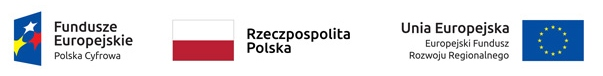</center>